In [50]:
import os
import random
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pydicom.pixel_data_handlers.util import apply_voi_lut

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["image.cmap"] = "gray"


In [51]:
TB_DIR = "../dataset/raw/rspaw/TB"
NON_TB_DIR = "../dataset/raw/rspaw/NonTB"

assert os.path.exists(TB_DIR), "Folder TB tidak ditemukan"
assert os.path.exists(NON_TB_DIR), "Folder NonTB tidak ditemukan"

In [52]:
def get_random_dicom(folder, n=2):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".dcm")]
    return random.sample(files, n)

tb_samples = get_random_dicom(TB_DIR, n=2)
nontb_samples = get_random_dicom(NON_TB_DIR, n=2)

print("TB samples:")
for f in tb_samples:
    print(" -", os.path.basename(f))

print("\nNonTB samples:")
for f in nontb_samples:
    print(" -", os.path.basename(f))

TB samples:
 - dicom-study-231017000532751-CR-THORAX[20231017].dcm
 - dicom-study-231019006332935-CR-thorax[20231019].dcm

NonTB samples:
 - pacs-dicom-study-240607002844351-CR-THORAX[20240607].dcm
 - pacs_rslt-dicom-study-CR-THORAX[20220619].dcm


In [53]:
def show_dicom_image(dcm_path, title=""):
    ds = pydicom.dcmread(dcm_path)

    # --- Load pixel data with VOI LUT if available ---
    if hasattr(ds, "WindowCenter") and hasattr(ds, "WindowWidth"):
        img = apply_voi_lut(ds.pixel_array, ds)
    else:
        img = ds.pixel_array

    img = img.astype(np.float32)

    # --- Min-max normalization (SAFE for visualization) ---
    min_val = np.min(img)
    max_val = np.max(img)

    if max_val > min_val:
        img = (img - min_val) / (max_val - min_val)
    else:
        img = np.zeros_like(img)

    # --- Plot explicitly as grayscale ---
    plt.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [54]:
def print_metadata_analysis(ds):
    tags = [
        ("Manufacturer", "domain shift"),
        ("ManufacturerModelName", "variasi hardware"),
        ("Modality", "validasi data (CR/DX)"),
        ("BodyPartExamined", "pastikan thorax"),
        ("StudyDate", "temporal bias"),
        ("PatientSex", "potensi confounder"),
        ("PatientAge", "filtering kohort"),
        ("ViewPosition", "PA / AP"),
    ]

    for tag, reason in tags:
        value = getattr(ds, tag, "NOT FOUND")
        print(f"{tag:22s}: {value}  --> {reason}")


===== ANALISIS TB =====

--- TB SAMPLE 1 ---


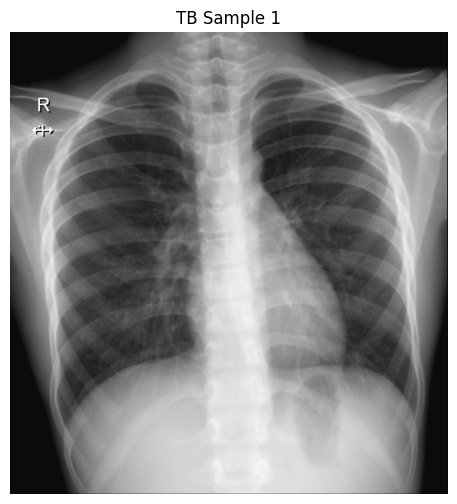

Manufacturer          : SIEMENS  --> domain shift
ManufacturerModelName : Fluorospot Compact FD  --> variasi hardware
Modality              : CR  --> validasi data (CR/DX)
BodyPartExamined      : CHEST  --> pastikan thorax
StudyDate             : 20231017  --> temporal bias
PatientSex            : M  --> potensi confounder
PatientAge            : 008Y  --> filtering kohort
ViewPosition          :   --> PA / AP

--- TB SAMPLE 2 ---


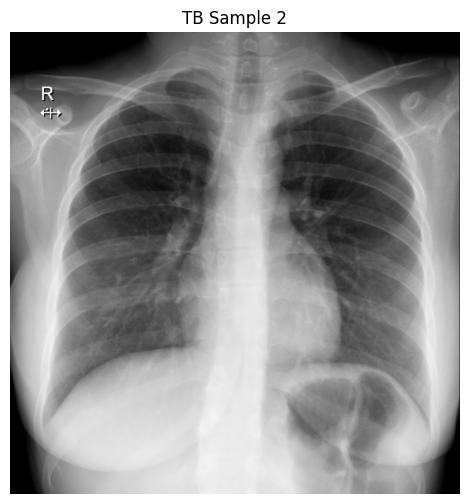

Manufacturer          : SIEMENS  --> domain shift
ManufacturerModelName : Fluorospot Compact FD  --> variasi hardware
Modality              : CR  --> validasi data (CR/DX)
BodyPartExamined      : CHEST  --> pastikan thorax
StudyDate             : 20231019  --> temporal bias
PatientSex            : F  --> potensi confounder
PatientAge            : 019Y  --> filtering kohort
ViewPosition          :   --> PA / AP


In [55]:
print("===== ANALISIS TB =====")

for i, path in enumerate(tb_samples, 1):
    print(f"\n--- TB SAMPLE {i} ---")
    ds = pydicom.dcmread(path)

    show_dicom_image(path, title=f"TB Sample {i}")
    print_metadata_analysis(ds)


===== ANALISIS NON-TB =====

--- NonTB SAMPLE 1 ---


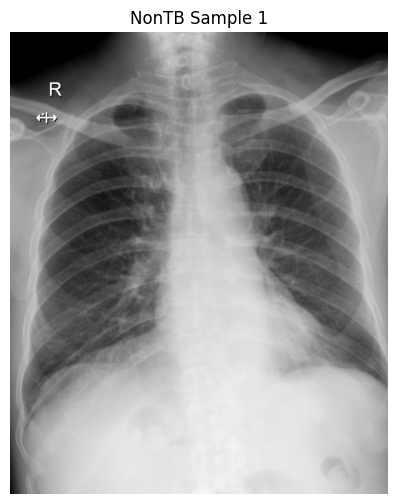

Manufacturer          : SIEMENS  --> domain shift
ManufacturerModelName : Fluorospot Compact FD  --> variasi hardware
Modality              : CR  --> validasi data (CR/DX)
BodyPartExamined      : CHEST  --> pastikan thorax
StudyDate             : 20240607  --> temporal bias
PatientSex            : M  --> potensi confounder
PatientAge            : 074Y  --> filtering kohort
ViewPosition          :   --> PA / AP

--- NonTB SAMPLE 2 ---


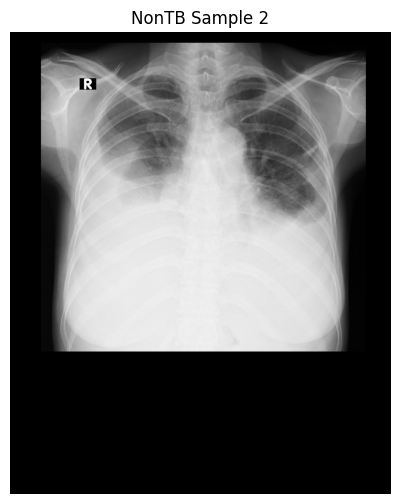

Manufacturer          : FUJIFILM Corporation  --> domain shift
ManufacturerModelName : NOT FOUND  --> variasi hardware
Modality              : CR  --> validasi data (CR/DX)
BodyPartExamined      : CHEST  --> pastikan thorax
StudyDate             : 20220619  --> temporal bias
PatientSex            : F  --> potensi confounder
PatientAge            : 053Y  --> filtering kohort
ViewPosition          :   --> PA / AP


In [56]:
print("===== ANALISIS NON-TB =====")

for i, path in enumerate(nontb_samples, 1):
    print(f"\n--- NonTB SAMPLE {i} ---")
    ds = pydicom.dcmread(path)

    show_dicom_image(path, title=f"NonTB Sample {i}")
    print_metadata_analysis(ds)


In [57]:
DATA_DIRS = [
    "../dataset/raw/rspaw/TB",
    "../dataset/raw/rspaw/NonTB"
]

records = []

for folder in DATA_DIRS:
    label = os.path.basename(folder)
    for fname in os.listdir(folder):
        if not fname.lower().endswith(".dcm"):
            continue

        fpath = os.path.join(folder, fname)
        try:
            ds = pydicom.dcmread(fpath, stop_before_pixels=True)
            manufacturer = getattr(ds, "Manufacturer", "UNKNOWN")
            modality = getattr(ds, "Modality", "UNKNOWN")
            body_part = getattr(ds, "BodyPartExamined", "UNKNOWN")
            view_position = getattr(ds, "ViewPosition", "UNKNOWN")
            width = getattr(ds, "Columns", "UNKNOWN")
            height = getattr(ds, "Rows", "UNKNOWN") 
            records.append({
                "label": label,
                "manufacturer": str(manufacturer).strip(),
                "modality": str(modality).strip(),
                "body_part": str(body_part).strip(),
                "view_position": str(view_position).strip(),
                "width": width,
                "height": height
            })
        except Exception as e:
            print("Gagal baca:", fpath, e)


=== UNIQUE MANUFACTURERS ===
- FUJIFILM Corporation
- SIEMENS

Total unique manufacturer: 2


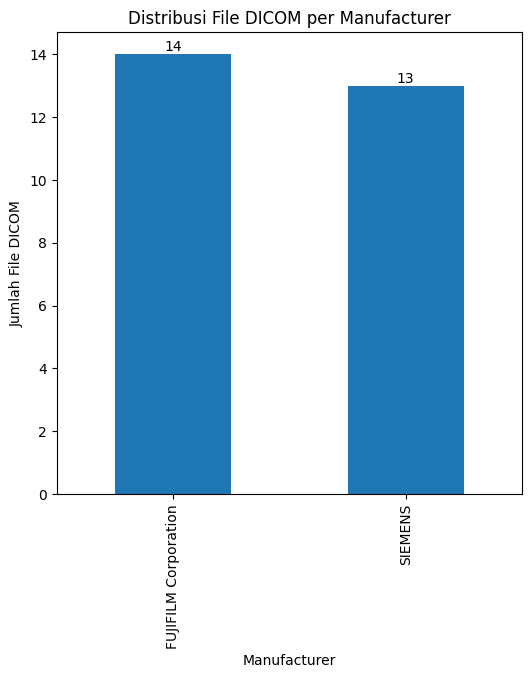

In [58]:
df = pd.DataFrame(records)

unique_manufacturers = sorted(df["manufacturer"].unique())
manufacturer_counts = (
    df.groupby("manufacturer")
      .size()
      .reset_index(name="num_files")
)

ax = manufacturer_counts.plot.bar(
    x="manufacturer",
    y="num_files",
    legend=False,
    title="Distribusi File DICOM per Manufacturer",
    ylabel="Jumlah File DICOM",
    xlabel="Manufacturer"
)

for container in ax.containers:
    ax.bar_label(container)
    
print("=== UNIQUE MANUFACTURERS ===")
for m in unique_manufacturers:
    print("-", m)

print("\nTotal unique manufacturer:", len(unique_manufacturers))


# Modality

=== UNIQUE MODALITY ===
- CR

Total unique modality: 1


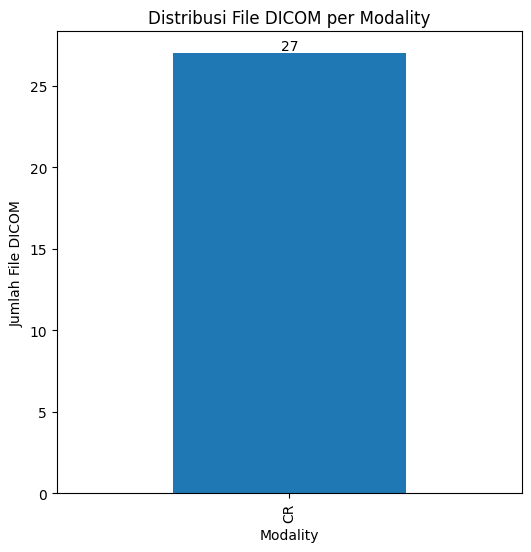

In [59]:
unique_modality = sorted(df["modality"].unique())
modality_counts = (
    df.groupby("modality")
      .size()
      .reset_index(name="num_files")
)

ax =modality_counts.plot.bar(
    x="modality",
    y="num_files",
    legend=False,
    title="Distribusi File DICOM per Modality",
    ylabel="Jumlah File DICOM",
    xlabel="Modality"
)

for container in ax.containers:
    ax.bar_label(container)

print("=== UNIQUE MODALITY ===")
for m in unique_modality:
    print("-", m)

print("\nTotal unique modality:", len(unique_modality))

# BodyPartExamined

=== UNIQUE BODY PART ===
- CHEST
- UP_EXM

Total unique body part: 2


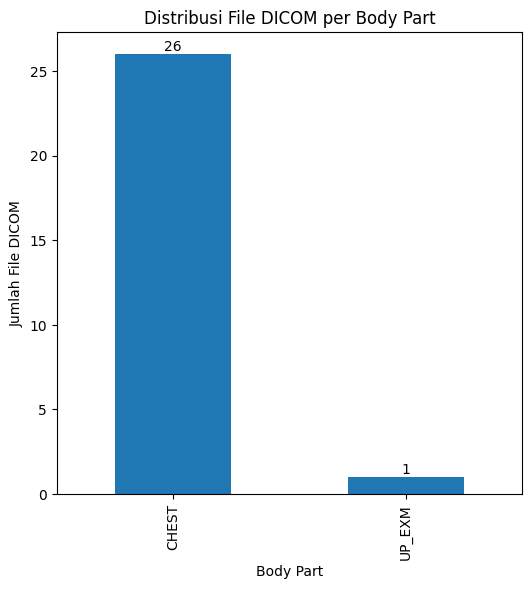

In [60]:
unique_body_part = sorted(df["body_part"].unique())
body_part_counts = (
    df.groupby("body_part")
      .size()
      .reset_index(name="num_files")
)

ax = body_part_counts.plot.bar(
    x="body_part",
    y="num_files",
    legend=False,
    title="Distribusi File DICOM per Body Part",
    ylabel="Jumlah File DICOM",
    xlabel="Body Part"
)

for container in ax.containers:
    ax.bar_label(container)

print("=== UNIQUE BODY PART ===")
for m in unique_body_part:
    print("-", m)

print("\nTotal unique body part:", len(unique_body_part))

In [61]:
df.columns

Index(['label', 'manufacturer', 'modality', 'body_part', 'view_position',
       'width', 'height'],
      dtype='object')

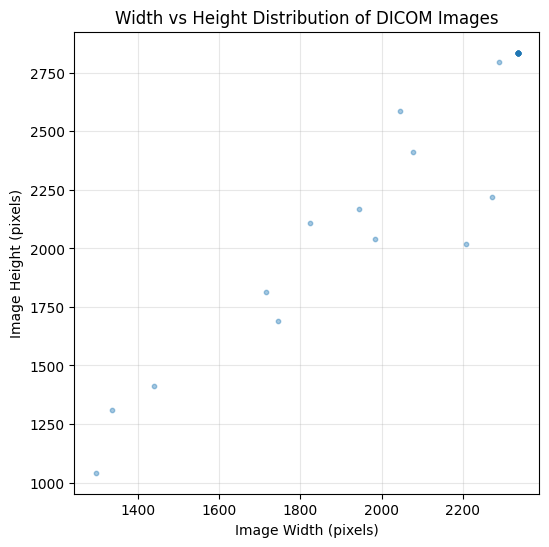

In [62]:
plt.figure(figsize=(6, 6))

plt.scatter(
    df["width"],
    df["height"],
    alpha=0.4,
    s=10
)

plt.xlabel("Image Width (pixels)")
plt.ylabel("Image Height (pixels)")
plt.title("Width vs Height Distribution of DICOM Images")
plt.grid(alpha=0.3)
plt.show()


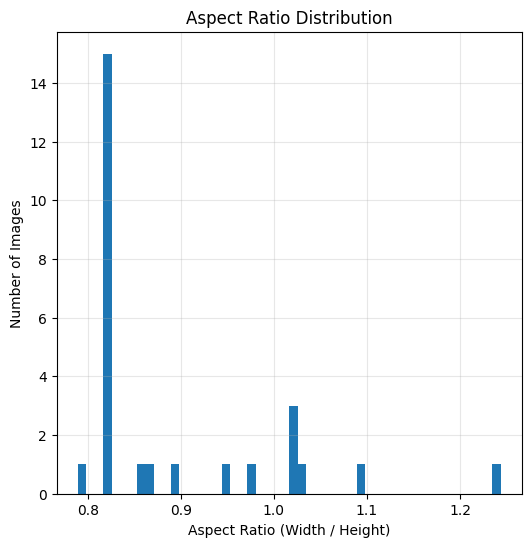

In [ ]:
df["aspect_ratio"] = df["width"] / df["height"]

plt.figure(figsize=(6, 4))
plt.hist(df["aspect_ratio"], bins=50)

plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Number of Images")
plt.title("Aspect Ratio Distribution")
plt.grid(alpha=0.3)
plt.show()


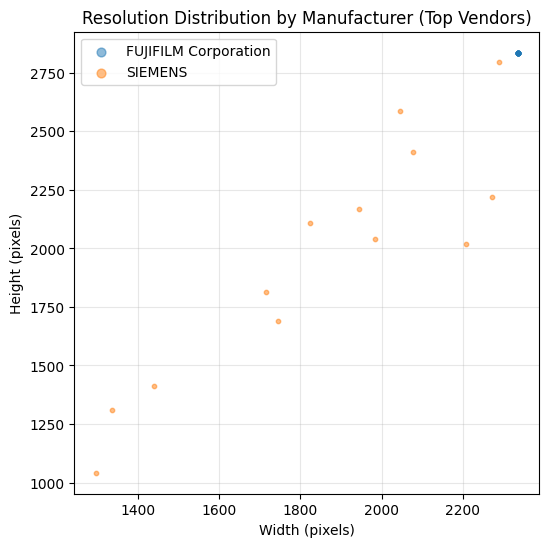

In [64]:
top_manufacturers = (
    manufacturer_counts
    .sort_values("num_files", ascending=False)
    .head(5)["manufacturer"]
    .tolist()
)
plt.figure(figsize=(6, 6))

for m in top_manufacturers:
    subset = df[df["manufacturer"] == m]
    plt.scatter(
        subset["width"],
        subset["height"],
        s=10,
        alpha=0.5,
        label=m
    )

plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("Resolution Distribution by Manufacturer (Top Vendors)")
plt.legend(markerscale=2)
plt.grid(alpha=0.3)
plt.show()


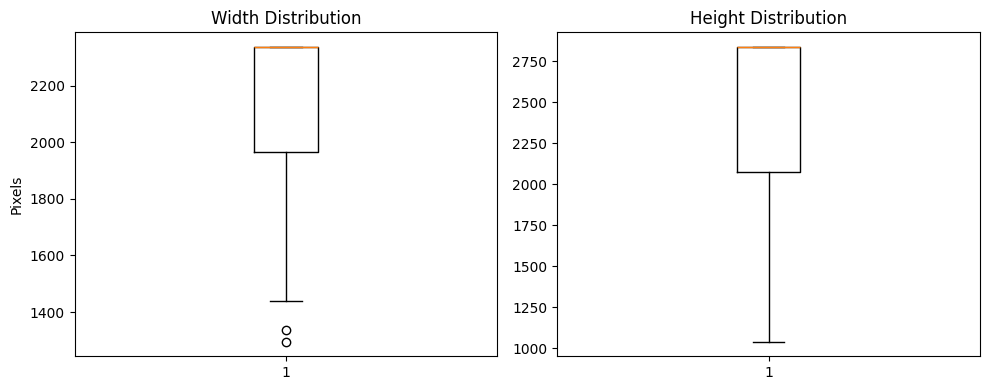

In [65]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(df["width"], vert=True)
plt.title("Width Distribution")
plt.ylabel("Pixels")

plt.subplot(1, 2, 2)
plt.boxplot(df["height"], vert=True)
plt.title("Height Distribution")

plt.tight_layout()
plt.show()


In [69]:
from tqdm import tqdm

def extract_pixel_stats(dcm_path):
    ds = pydicom.dcmread(dcm_path)
    img = ds.pixel_array.astype(np.float32)

    return {
        "dtype": str(ds.pixel_array.dtype),
        "min": float(img.min()),
        "max": float(img.max()),
        "mean": float(img.mean()),
        "std": float(img.std())
    }

pixel_records = []

for folder in DATA_DIRS:
    label = os.path.basename(folder)
    files = [f for f in os.listdir(folder) if f.lower().endswith(".dcm")]
    files = files[:SAMPLE_PER_CLASS]

    for fname in tqdm(files, desc=f"Pixel stats {label}"):
        path = os.path.join(folder, fname)
        try:
            stats = extract_pixel_stats(path)
            stats["label"] = label
            pixel_records.append(stats)
        except:
            pass


Pixel stats TB:   0%|          | 0/2 [00:00<?, ?it/s]

Pixel stats NonTB: 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]


In [70]:
pixel_df = pd.DataFrame(pixel_records)

pixel_df.groupby("label")[["min", "max", "mean", "std"]].describe()


min                                            max         ...  \
      count  mean  std   min   25%   50%   75%   max count   mean  ...   
label                                                              ...   
NonTB   2.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0   2.0  255.0  ...   
TB      2.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   2.0  255.0  ...   

             mean               std                                  \
              75%         max count       mean       std        min   
label                                                                 
NonTB  145.717541  148.909760   2.0  60.806931  1.078954  60.043995   
TB     116.856421  120.267731   2.0  69.330555  5.058663  65.753540   

                                                   
             25%        50%        75%        max  
label                                              
NonTB  60.425463  60.806931  61.188398  61.569866  
TB     67.542048  69.330555  71.119062  72.907570  

[2 rows x 32 columns]

In [71]:
pixel_df["dtype"].value_counts()


dtype
uint8    4
Name: count, dtype: int64

In [72]:
view_counts = (
    df["view_position"]
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={"index": "view_position", "view_position": "count"})
)

view_counts


,count,count
0,,27


In [73]:
pd.crosstab(df["view_position"], df["label"], normalize="columns")


label,NonTB,TB
view_position,,
,1.0,1.0


In [74]:
missing_rate = (
    df.isna().mean()
    .reset_index()
    .rename(columns={"index": "field", 0: "missing_fraction"})
)

missing_rate


,field,missing_fraction
0,label,0.0
1,manufacturer,0.0
2,modality,0.0
3,body_part,0.0
4,view_position,0.0
5,width,0.0
6,height,0.0
7,aspect_ratio,0.0


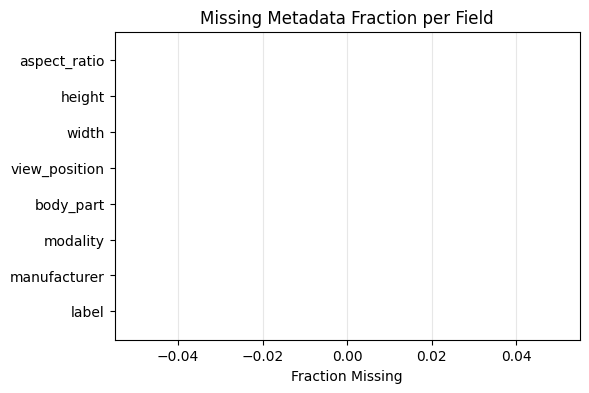

In [75]:
plt.figure(figsize=(6, 4))
plt.barh(missing_rate["field"], missing_rate["missing_fraction"])
plt.xlabel("Fraction Missing")
plt.title("Missing Metadata Fraction per Field")
plt.grid(axis="x", alpha=0.3)
plt.show()


In [76]:
manufacturer_label = pd.crosstab(
    df["manufacturer"],
    df["label"],
    normalize="columns"
)

manufacturer_label


label,NonTB,TB
manufacturer,,
FUJIFILM Corporation,0.785714,0.230769
SIEMENS,0.214286,0.769231


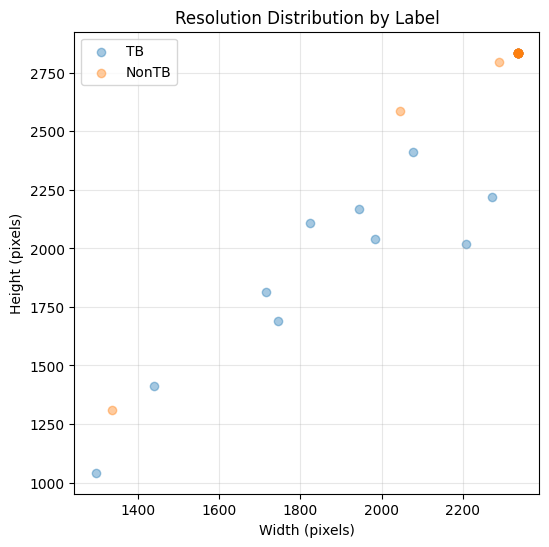

In [77]:
plt.figure(figsize=(6, 6))

for label in df["label"].unique():
    subset = df[df["label"] == label]
    plt.scatter(
        subset["width"],
        subset["height"],
        alpha=0.4,
        label=label
    )

plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("Resolution Distribution by Label")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
print("===== EDA SUMMARY =====")
print(f"Total images        : {len(df)}")
print(f"Unique manufacturers: {df['manufacturer'].nunique()}")
print(f"Resolution range    : {df['width'].min()}–{df['width'].max()} x "
      f"{df['height'].min()}–{df['height'].max()}")
print("Dominant view pos   :")
print(df["view_position"].value_counts().head())

===== EDA SUMMARY =====
Total images        : 27
Unique manufacturers: 2
Resolution range    : 1296–2336 x 1042–2836
Dominant view pos   :
view_position
    27
Name: count, dtype: int64

EDA completed without preprocessing.
